In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import datetime

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

import pickle

In [2]:
inicio = datetime.datetime.today()

In [3]:
print(tf. __version__)

2.12.0


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## TensorBoard

In [5]:
log_directory = 'logs\\fit_' + datetime.datetime.now().strftime("%Y-%m-%d--%H-%M")
board = TensorBoard(log_dir=log_directory,histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=1)

In [6]:
pwd

tensorboard --logdir logs\fit 

http://localhost:6006/#scalars

## Import Dataset

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

In [7]:
data_dir = 'C:\\Users\\andre\\Documents\\Datasets\\flower_photos'

In [8]:
total_imagenes = 0
for i in os.scandir(data_dir):
    if i.is_dir():
        print(f'La carpeta {i.name} tiene {len(os.listdir(i))} imagenes')
        total_imagenes += len(os.listdir(i))
print('------------')
print(f'El total de imagenes es {total_imagenes}')

La carpeta daisy tiene 633 imagenes
La carpeta dandelion tiene 898 imagenes
La carpeta roses tiene 641 imagenes
La carpeta sunflowers tiene 699 imagenes
La carpeta tulips tiene 799 imagenes
------------
El total de imagenes es 3670


In [9]:
roses = os.listdir(data_dir+'/roses')
roses = [data_dir + '/roses/' + flower for flower in roses] 

In [10]:
imread(roses[0]).shape

(240, 179, 3)

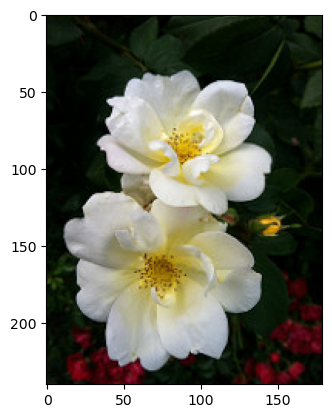

In [11]:
plt.imshow(imread(roses[0]))

# Data Pre-processing

## Finding the best shape

In [12]:
counter = 0
dim1 = []
dim2 = []
colors_temp = []
for i in os.scandir(data_dir):
    if i.is_dir():
        actual = os.listdir(data_dir+'/' + i.name)
        for j in actual:
            counter +=1
            img = imread(data_dir + '/' + i.name + '/' + j)
            d1,d2,colors = img.shape
            dim1.append(d1)
            dim2.append(d2)
            colors_temp.append(colors)
            

In [13]:
print(counter)
print(np.array(dim1).mean())
print(np.array(dim2).mean())
print(pd.Series(colors_temp).unique())

3670
271.79128065395093
365.0623978201635
[3]


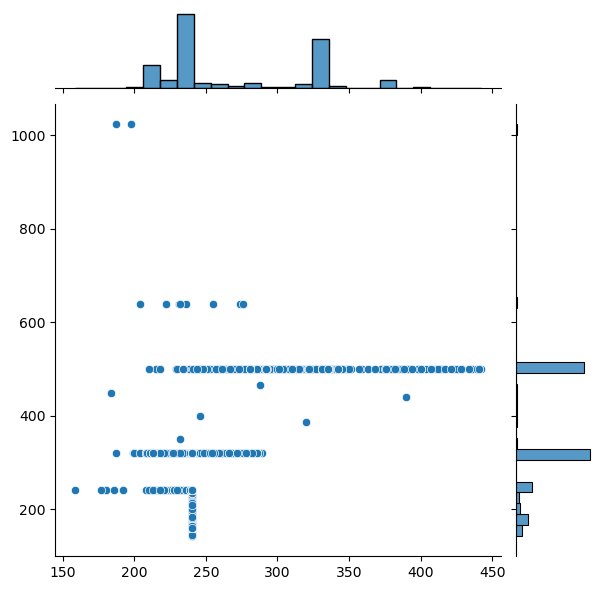

In [14]:
sns.jointplot(x = dim1,y = dim2)

## Train/Test Split

In [15]:
## Cambiarlo al promedio
batch_size = 32
img_height = 180
img_width = 180

In [16]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [17]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [64]:
pd.Series(true_categories).value_counts()

1    176
4    157
3    152
0    129
2    120
dtype: int64

In [61]:
# Experimento para hacer lo mismo de arriba en un solo paso
# train_ds_e, val_ds_e = tf.keras.utils.image_dataset_from_directory(
#   data_dir,
#   validation_split=0.2,
#   subset="both",
#   seed=123,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Using 734 files for validation.


In [19]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


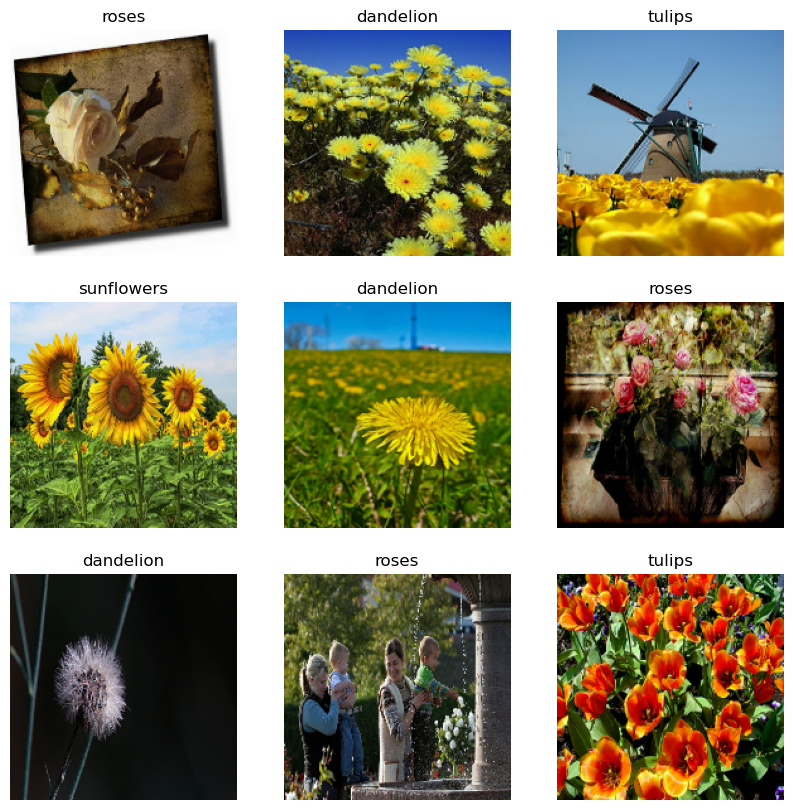

In [20]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [21]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


## Creating the Normalization Layer

In [22]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

## Configure the dataset for performance

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Creating the Model

In [24]:
num_classes = 5

# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Rescaling(1./255))
# model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D())
# model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D())
# model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D())
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(128, activation='relu'))
# model.add(tf.keras.layers.Dense(num_classes))

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [25]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=600, 
    use_multiprocessing = True
)

Epoch 1/600
92/92 [==============================] - 32s 340ms/step - loss: 1.3626 - accuracy: 0.3910 - val_loss: 1.0700 - val_accuracy: 0.5668
Epoch 2/600
92/92 [==============================] - 30s 327ms/step - loss: 1.0670 - accuracy: 0.5616 - val_loss: 1.0208 - val_accuracy: 0.5695
Epoch 3/600
92/92 [==============================] - 30s 328ms/step - loss: 0.9091 - accuracy: 0.6437 - val_loss: 0.9178 - val_accuracy: 0.6376
Epoch 4/600
92/92 [==============================] - 29s 319ms/step - loss: 0.7755 - accuracy: 0.7037 - val_loss: 1.0354 - val_accuracy: 0.6308
Epoch 5/600
92/92 [==============================] - 29s 318ms/step - loss: 0.6497 - accuracy: 0.7531 - val_loss: 1.1001 - val_accuracy: 0.6253
Epoch 6/600
92/92 [==============================] - 29s 319ms/step - loss: 0.4897 - accuracy: 0.8243 - val_loss: 1.1517 - val_accuracy: 0.6104
Epoch 7/600
92/92 [==============================] - 29s 319ms/step - loss: 0.3666 - accuracy: 0.8682 - val_loss: 1.2600 - val_accuracy:

92/92 [==============================] - 30s 325ms/step - loss: 1.4953e-05 - accuracy: 1.0000 - val_loss: 3.3434 - val_accuracy: 0.6935
Epoch 57/600
92/92 [==============================] - 30s 324ms/step - loss: 1.4070e-05 - accuracy: 1.0000 - val_loss: 3.3556 - val_accuracy: 0.6935
Epoch 58/600
92/92 [==============================] - 31s 335ms/step - loss: 1.3211e-05 - accuracy: 1.0000 - val_loss: 3.3730 - val_accuracy: 0.6935
Epoch 59/600
92/92 [==============================] - 31s 341ms/step - loss: 1.2365e-05 - accuracy: 1.0000 - val_loss: 3.3890 - val_accuracy: 0.6935
Epoch 60/600
92/92 [==============================] - 30s 329ms/step - loss: 1.1604e-05 - accuracy: 1.0000 - val_loss: 3.4033 - val_accuracy: 0.6935
Epoch 61/600
92/92 [==============================] - 30s 326ms/step - loss: 1.0896e-05 - accuracy: 1.0000 - val_loss: 3.4190 - val_accuracy: 0.6935
Epoch 62/600
92/92 [==============================] - 30s 327ms/step - loss: 1.0311e-05 - accuracy: 1.0000 - val_loss: 

Epoch 111/600
92/92 [==============================] - 29s 321ms/step - loss: 6.6738e-07 - accuracy: 1.0000 - val_loss: 4.1497 - val_accuracy: 0.6853
Epoch 112/600
92/92 [==============================] - 29s 320ms/step - loss: 6.3409e-07 - accuracy: 1.0000 - val_loss: 4.1617 - val_accuracy: 0.6853
Epoch 113/600
92/92 [==============================] - 30s 323ms/step - loss: 6.0185e-07 - accuracy: 1.0000 - val_loss: 4.1763 - val_accuracy: 0.6853
Epoch 114/600
92/92 [==============================] - 29s 320ms/step - loss: 5.7075e-07 - accuracy: 1.0000 - val_loss: 4.1897 - val_accuracy: 0.6853
Epoch 115/600
92/92 [==============================] - 29s 318ms/step - loss: 5.4196e-07 - accuracy: 1.0000 - val_loss: 4.2025 - val_accuracy: 0.6839
Epoch 116/600
92/92 [==============================] - 30s 321ms/step - loss: 5.1480e-07 - accuracy: 1.0000 - val_loss: 4.2161 - val_accuracy: 0.6839
Epoch 117/600
92/92 [==============================] - 29s 318ms/step - loss: 4.8861e-07 - accuracy:

92/92 [==============================] - 30s 324ms/step - loss: 4.2470e-08 - accuracy: 1.0000 - val_loss: 4.8391 - val_accuracy: 0.6757
Epoch 166/600
92/92 [==============================] - 30s 322ms/step - loss: 4.0481e-08 - accuracy: 1.0000 - val_loss: 4.8483 - val_accuracy: 0.6757
Epoch 167/600
92/92 [==============================] - 30s 327ms/step - loss: 3.8938e-08 - accuracy: 1.0000 - val_loss: 4.8624 - val_accuracy: 0.6757
Epoch 168/600
92/92 [==============================] - 30s 324ms/step - loss: 3.7233e-08 - accuracy: 1.0000 - val_loss: 4.8741 - val_accuracy: 0.6757
Epoch 169/600
92/92 [==============================] - 29s 320ms/step - loss: 3.5365e-08 - accuracy: 1.0000 - val_loss: 4.8864 - val_accuracy: 0.6757
Epoch 170/600
92/92 [==============================] - 30s 322ms/step - loss: 3.3091e-08 - accuracy: 1.0000 - val_loss: 4.8976 - val_accuracy: 0.6757
Epoch 171/600
92/92 [==============================] - 30s 329ms/step - loss: 3.0980e-08 - accuracy: 1.0000 - val_

Epoch 220/600
92/92 [==============================] - 29s 320ms/step - loss: 3.4918e-09 - accuracy: 1.0000 - val_loss: 5.5844 - val_accuracy: 0.6689
Epoch 221/600
92/92 [==============================] - 30s 323ms/step - loss: 3.4918e-09 - accuracy: 1.0000 - val_loss: 5.6139 - val_accuracy: 0.6689
Epoch 222/600
92/92 [==============================] - 30s 322ms/step - loss: 3.3700e-09 - accuracy: 1.0000 - val_loss: 5.6458 - val_accuracy: 0.6703
Epoch 223/600
92/92 [==============================] - 29s 315ms/step - loss: 3.2888e-09 - accuracy: 1.0000 - val_loss: 5.6769 - val_accuracy: 0.6703
Epoch 224/600
92/92 [==============================] - 29s 315ms/step - loss: 3.4512e-09 - accuracy: 1.0000 - val_loss: 5.7138 - val_accuracy: 0.6703
Epoch 225/600
92/92 [==============================] - 29s 314ms/step - loss: 3.2482e-09 - accuracy: 1.0000 - val_loss: 5.7447 - val_accuracy: 0.6717
Epoch 226/600
92/92 [==============================] - 29s 316ms/step - loss: 3.5324e-09 - accuracy:

Epoch 275/600
92/92 [==============================] - 29s 316ms/step - loss: 1.7594e-05 - accuracy: 1.0000 - val_loss: 3.5879 - val_accuracy: 0.6580
Epoch 276/600
92/92 [==============================] - 29s 314ms/step - loss: 1.6169e-05 - accuracy: 1.0000 - val_loss: 3.6016 - val_accuracy: 0.6580
Epoch 277/600
92/92 [==============================] - 29s 317ms/step - loss: 1.4793e-05 - accuracy: 1.0000 - val_loss: 3.6175 - val_accuracy: 0.6580
Epoch 278/600
92/92 [==============================] - 29s 315ms/step - loss: 1.3566e-05 - accuracy: 1.0000 - val_loss: 3.6320 - val_accuracy: 0.6608
Epoch 279/600
92/92 [==============================] - 29s 315ms/step - loss: 1.2436e-05 - accuracy: 1.0000 - val_loss: 3.6464 - val_accuracy: 0.6594
Epoch 280/600
92/92 [==============================] - 29s 317ms/step - loss: 1.1528e-05 - accuracy: 1.0000 - val_loss: 3.6586 - val_accuracy: 0.6621
Epoch 281/600
92/92 [==============================] - 29s 319ms/step - loss: 1.0693e-05 - accuracy:

92/92 [==============================] - 29s 311ms/step - loss: 6.3888e-07 - accuracy: 1.0000 - val_loss: 4.2054 - val_accuracy: 0.6608
Epoch 330/600
92/92 [==============================] - 29s 317ms/step - loss: 6.0762e-07 - accuracy: 1.0000 - val_loss: 4.2158 - val_accuracy: 0.6608
Epoch 331/600
92/92 [==============================] - 29s 312ms/step - loss: 5.7944e-07 - accuracy: 1.0000 - val_loss: 4.2233 - val_accuracy: 0.6608
Epoch 332/600
92/92 [==============================] - 29s 316ms/step - loss: 5.5260e-07 - accuracy: 1.0000 - val_loss: 4.2338 - val_accuracy: 0.6608
Epoch 333/600
92/92 [==============================] - 29s 314ms/step - loss: 5.2726e-07 - accuracy: 1.0000 - val_loss: 4.2441 - val_accuracy: 0.6608
Epoch 334/600
92/92 [==============================] - 29s 314ms/step - loss: 5.0177e-07 - accuracy: 1.0000 - val_loss: 4.2539 - val_accuracy: 0.6608
Epoch 335/600
92/92 [==============================] - 29s 316ms/step - loss: 4.7943e-07 - accuracy: 1.0000 - val_

Epoch 384/600
92/92 [==============================] - 29s 313ms/step - loss: 4.5922e-08 - accuracy: 1.0000 - val_loss: 4.7495 - val_accuracy: 0.6594
Epoch 385/600
92/92 [==============================] - 29s 315ms/step - loss: 4.3648e-08 - accuracy: 1.0000 - val_loss: 4.7592 - val_accuracy: 0.6594
Epoch 386/600
92/92 [==============================] - 30s 322ms/step - loss: 4.1536e-08 - accuracy: 1.0000 - val_loss: 4.7700 - val_accuracy: 0.6594
Epoch 387/600
92/92 [==============================] - 29s 318ms/step - loss: 3.9547e-08 - accuracy: 1.0000 - val_loss: 4.7799 - val_accuracy: 0.6594
Epoch 388/600
92/92 [==============================] - 29s 317ms/step - loss: 3.7639e-08 - accuracy: 1.0000 - val_loss: 4.7907 - val_accuracy: 0.6594
Epoch 389/600
92/92 [==============================] - 29s 319ms/step - loss: 3.5812e-08 - accuracy: 1.0000 - val_loss: 4.8003 - val_accuracy: 0.6594
Epoch 390/600
92/92 [==============================] - 29s 320ms/step - loss: 3.4228e-08 - accuracy:

92/92 [==============================] - 29s 313ms/step - loss: 3.0452e-09 - accuracy: 1.0000 - val_loss: 5.3997 - val_accuracy: 0.6580
Epoch 439/600
92/92 [==============================] - 29s 312ms/step - loss: 3.3294e-09 - accuracy: 1.0000 - val_loss: 5.4180 - val_accuracy: 0.6580
Epoch 440/600
92/92 [==============================] - 29s 312ms/step - loss: 3.0452e-09 - accuracy: 1.0000 - val_loss: 5.4363 - val_accuracy: 0.6580
Epoch 441/600
92/92 [==============================] - 29s 311ms/step - loss: 2.8828e-09 - accuracy: 1.0000 - val_loss: 5.4563 - val_accuracy: 0.6580
Epoch 442/600
92/92 [==============================] - 29s 313ms/step - loss: 2.8422e-09 - accuracy: 1.0000 - val_loss: 5.4756 - val_accuracy: 0.6580
Epoch 443/600
92/92 [==============================] - 29s 314ms/step - loss: 2.8828e-09 - accuracy: 1.0000 - val_loss: 5.4950 - val_accuracy: 0.6580
Epoch 444/600
92/92 [==============================] - 29s 314ms/step - loss: 2.5174e-09 - accuracy: 1.0000 - val_

Epoch 493/600
92/92 [==============================] - 29s 319ms/step - loss: 4.1937e-04 - accuracy: 1.0000 - val_loss: 2.9515 - val_accuracy: 0.6730
Epoch 494/600
92/92 [==============================] - 29s 319ms/step - loss: 3.1808e-04 - accuracy: 1.0000 - val_loss: 2.9895 - val_accuracy: 0.6730
Epoch 495/600
92/92 [==============================] - 30s 321ms/step - loss: 2.4471e-04 - accuracy: 1.0000 - val_loss: 3.0276 - val_accuracy: 0.6730
Epoch 496/600
92/92 [==============================] - 29s 316ms/step - loss: 1.9844e-04 - accuracy: 1.0000 - val_loss: 3.0599 - val_accuracy: 0.6730
Epoch 497/600
92/92 [==============================] - 29s 312ms/step - loss: 1.6450e-04 - accuracy: 1.0000 - val_loss: 3.0925 - val_accuracy: 0.6757
Epoch 498/600
92/92 [==============================] - 29s 312ms/step - loss: 1.3933e-04 - accuracy: 1.0000 - val_loss: 3.1184 - val_accuracy: 0.6771
Epoch 499/600
92/92 [==============================] - 29s 312ms/step - loss: 1.1872e-04 - accuracy:

92/92 [==============================] - 29s 310ms/step - loss: 2.6990e-06 - accuracy: 1.0000 - val_loss: 3.7335 - val_accuracy: 0.6785
Epoch 548/600
92/92 [==============================] - 29s 311ms/step - loss: 2.5498e-06 - accuracy: 1.0000 - val_loss: 3.7423 - val_accuracy: 0.6785
Epoch 549/600
92/92 [==============================] - 28s 310ms/step - loss: 2.4079e-06 - accuracy: 1.0000 - val_loss: 3.7526 - val_accuracy: 0.6785
Epoch 550/600
92/92 [==============================] - 29s 310ms/step - loss: 2.2776e-06 - accuracy: 1.0000 - val_loss: 3.7609 - val_accuracy: 0.6785
Epoch 551/600
92/92 [==============================] - 29s 311ms/step - loss: 2.1548e-06 - accuracy: 1.0000 - val_loss: 3.7704 - val_accuracy: 0.6785
Epoch 552/600
92/92 [==============================] - 28s 310ms/step - loss: 2.0386e-06 - accuracy: 1.0000 - val_loss: 3.7788 - val_accuracy: 0.6785
Epoch 553/600
92/92 [==============================] - 29s 310ms/step - loss: 1.9237e-06 - accuracy: 1.0000 - val_

## Evaluation

In [26]:
model.history.history

{'loss': [1.362580418586731,
  1.0670138597488403,
  0.9090647101402283,
  0.7754825353622437,
  0.6496963500976562,
  0.48969462513923645,
  0.36664658784866333,
  0.30166199803352356,
  0.29747968912124634,
  0.23890753090381622,
  0.18871569633483887,
  0.14475685358047485,
  0.08156599849462509,
  0.027041584253311157,
  0.015156394802033901,
  0.006603826303035021,
  0.004758007358759642,
  0.003101825714111328,
  0.0017882022075355053,
  0.0007307655178010464,
  0.0004907263210043311,
  0.00039016493246890604,
  0.00032057470525614917,
  0.00026879366487264633,
  0.000229387849685736,
  0.00019834088743664324,
  0.00017411189037375152,
  0.00015396546223200858,
  0.00013639283133670688,
  0.0001221163256559521,
  0.00010900165216298774,
  9.79937904048711e-05,
  8.902883564587682e-05,
  8.09649791335687e-05,
  7.335332338698208e-05,
  6.771073094569147e-05,
  6.14765813224949e-05,
  5.6619195675011724e-05,
  5.209132359595969e-05,
  4.795123459189199e-05,
  4.451896529644728e-05,

<Axes: >

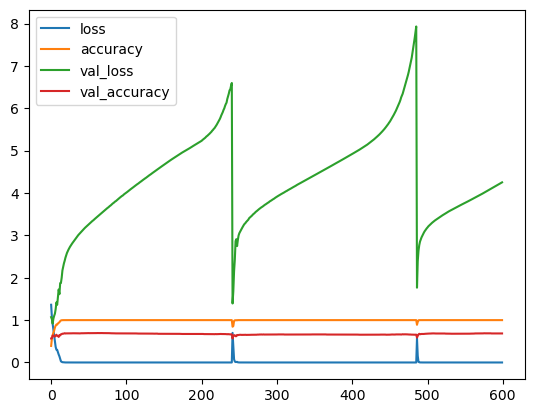

In [27]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [28]:
model.metrics_names

['loss', 'accuracy']

In [37]:
training_score = model.evaluate(train_ds,verbose=1)
test_score = model.evaluate(val_ds,verbose=1)

23/23 [==============================] - 1s 59ms/step - loss: 4.2521 - accuracy: 0.6853


In [38]:
print(training_score)
print(test_score)

[1.5749742487969343e-07, 1.0]
[4.252054214477539, 0.6852861046791077]


In [39]:
predictions = model.predict(val_ds)

23/23 [==============================] - 1s 59ms/step


In [40]:
predictions

array([[-8.0134420e+00,  1.1754016e+01, -2.6450163e+01, -4.2897366e+01,
        -1.5306821e+01],
       [ 9.6027384e+00, -1.2457906e+01, -2.0279449e+01, -7.2913394e+00,
        -4.6360135e+00],
       [ 3.7237201e+00, -1.0553655e+01, -2.3578381e+01,  5.3551259e+00,
        -6.5488000e+00],
       ...,
       [-6.5648189e+00, -4.4851546e+00, -1.1245485e+01, -1.6397329e+01,
        -1.3239042e+01],
       [ 1.1459247e+01,  1.2419254e-02, -3.2237415e+01, -3.5057388e+01,
        -2.1012194e+01],
       [-1.4171854e+01, -1.6599941e+00, -1.8085115e+01, -3.8836704e+01,
        -2.5030565e+01]], dtype=float32)

In [41]:
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [42]:
predictions = pd.Series(np.argmax(predictions,axis=1))

In [43]:
predictions

0      1
1      0
2      3
3      0
4      3
      ..
729    4
730    4
731    1
732    0
733    1
Length: 734, dtype: int64

In [44]:
predictions = pd.Series(predictions).replace(np.linspace(0,len(class_names)-1, len(class_names)), class_names)

In [45]:
predictions

0       dandelion
1           daisy
2      sunflowers
3           daisy
4      sunflowers
          ...    
729        tulips
730        tulips
731     dandelion
732         daisy
733     dandelion
Length: 734, dtype: object

In [46]:
true_categories = tf.concat([y for x, y in val_ds], axis=0).numpy()

In [47]:
true_categories

array([0, 4, 3, 0, 3, 4, 1, 2, 4, 0, 0, 0, 4, 4, 4, 3, 3, 0, 0, 3, 1, 4,
       4, 2, 3, 3, 1, 2, 1, 2, 4, 1, 1, 0, 2, 2, 3, 1, 3, 4, 2, 3, 4, 4,
       3, 4, 4, 3, 4, 1, 4, 1, 4, 1, 1, 1, 1, 2, 0, 2, 2, 1, 1, 1, 3, 1,
       0, 3, 4, 1, 0, 2, 3, 0, 3, 1, 0, 0, 3, 0, 4, 2, 3, 1, 4, 3, 1, 4,
       2, 1, 1, 0, 1, 2, 4, 2, 0, 2, 4, 3, 2, 1, 1, 2, 0, 0, 1, 4, 3, 0,
       4, 2, 0, 0, 0, 1, 0, 4, 4, 4, 0, 4, 4, 3, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 3, 0, 3, 4, 2, 3, 0, 3, 2, 2, 3, 2, 4, 3, 4, 0, 4, 2, 2, 0,
       2, 1, 0, 3, 2, 3, 0, 2, 4, 3, 0, 2, 3, 3, 4, 0, 1, 2, 3, 0, 4, 3,
       3, 1, 3, 2, 3, 1, 1, 2, 1, 4, 0, 1, 3, 3, 2, 2, 4, 1, 3, 1, 4, 1,
       1, 0, 1, 4, 3, 1, 1, 3, 3, 4, 1, 1, 0, 4, 1, 1, 1, 1, 3, 4, 3, 0,
       2, 2, 1, 4, 1, 1, 3, 1, 0, 0, 4, 4, 0, 1, 4, 3, 4, 4, 0, 2, 3, 3,
       3, 4, 0, 2, 4, 1, 1, 0, 1, 0, 3, 3, 4, 2, 0, 3, 4, 4, 1, 0, 2, 4,
       0, 2, 4, 4, 3, 1, 4, 2, 3, 3, 3, 3, 3, 1, 4, 4, 3, 2, 2, 3, 3, 0,
       3, 1, 1, 4, 4, 1, 4, 4, 3, 4, 0, 1, 1, 2, 0,

In [48]:
true_categories = pd.Series(true_categories).replace(np.linspace(0,len(class_names)-1, len(class_names)), class_names)

In [49]:
true_categories

0           daisy
1          tulips
2      sunflowers
3           daisy
4      sunflowers
          ...    
729        tulips
730        tulips
731        tulips
732         daisy
733     dandelion
Length: 734, dtype: object

In [50]:
metrics.accuracy_score(predictions, true_categories)

0.6852861035422343

In [51]:
metrics.confusion_matrix(predictions, true_categories)

array([[ 77,  15,   9,  12,  14],
       [ 28, 134,  10,   7,   7],
       [ 10,   7,  66,   3,  23],
       [  7,  13,   5, 125,  12],
       [  7,   7,  30,   5, 101]], dtype=int64)

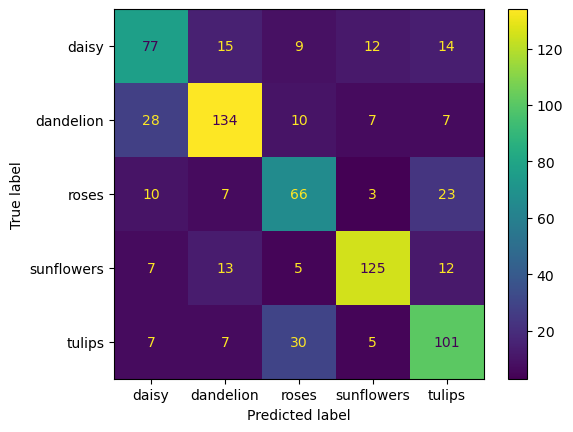

In [53]:
cm = metrics.confusion_matrix(predictions, true_categories)
metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=class_names).plot()

In [54]:
print(metrics.classification_report(predictions, true_categories))

              precision    recall  f1-score   support

       daisy       0.60      0.61      0.60       127
   dandelion       0.76      0.72      0.74       186
       roses       0.55      0.61      0.58       109
  sunflowers       0.82      0.77      0.80       162
      tulips       0.64      0.67      0.66       150

    accuracy                           0.69       734
   macro avg       0.67      0.68      0.67       734
weighted avg       0.69      0.69      0.69       734



In [55]:
final = datetime.datetime.today()

In [56]:
tiempo_transcurrido = final - inicio

In [57]:
tiempo_transcurrido.seconds

18098

In [58]:
tiempo_transcurrido.seconds/60

301.6333333333333

In [59]:
tiempo_transcurrido.seconds/(60*60)

5.027222222222222

## Early Stopping

In [ ]:
num_classes = 5

# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Rescaling(1./255))
# model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D())
# model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D())
# model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D())
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(128, activation='relu'))
# model.add(tf.keras.layers.Dense(num_classes))

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [ ]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=600, 
    use_multiprocessing = True,
    callbacks=[early_stop, board]
)

## Evaluation

In [26]:
model.history.history

{'loss': [1.362580418586731,
  1.0670138597488403,
  0.9090647101402283,
  0.7754825353622437,
  0.6496963500976562,
  0.48969462513923645,
  0.36664658784866333,
  0.30166199803352356,
  0.29747968912124634,
  0.23890753090381622,
  0.18871569633483887,
  0.14475685358047485,
  0.08156599849462509,
  0.027041584253311157,
  0.015156394802033901,
  0.006603826303035021,
  0.004758007358759642,
  0.003101825714111328,
  0.0017882022075355053,
  0.0007307655178010464,
  0.0004907263210043311,
  0.00039016493246890604,
  0.00032057470525614917,
  0.00026879366487264633,
  0.000229387849685736,
  0.00019834088743664324,
  0.00017411189037375152,
  0.00015396546223200858,
  0.00013639283133670688,
  0.0001221163256559521,
  0.00010900165216298774,
  9.79937904048711e-05,
  8.902883564587682e-05,
  8.09649791335687e-05,
  7.335332338698208e-05,
  6.771073094569147e-05,
  6.14765813224949e-05,
  5.6619195675011724e-05,
  5.209132359595969e-05,
  4.795123459189199e-05,
  4.451896529644728e-05,

<Axes: >

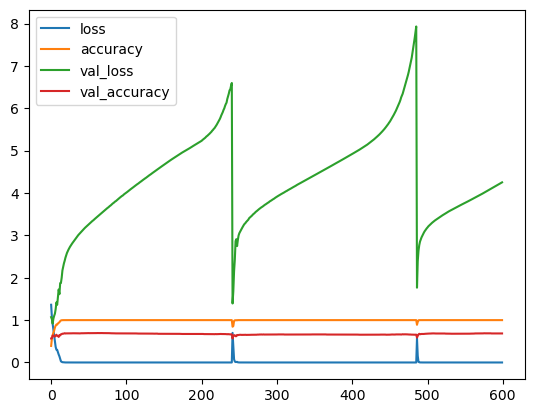

In [27]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [28]:
model.metrics_names

['loss', 'accuracy']

In [37]:
training_score = model.evaluate(train_ds,verbose=1)
test_score = model.evaluate(val_ds,verbose=1)

23/23 [==============================] - 1s 59ms/step - loss: 4.2521 - accuracy: 0.6853


In [38]:
print(training_score)
print(test_score)

[1.5749742487969343e-07, 1.0]
[4.252054214477539, 0.6852861046791077]


In [39]:
predictions = model.predict(val_ds)

23/23 [==============================] - 1s 59ms/step


In [40]:
predictions

array([[-8.0134420e+00,  1.1754016e+01, -2.6450163e+01, -4.2897366e+01,
        -1.5306821e+01],
       [ 9.6027384e+00, -1.2457906e+01, -2.0279449e+01, -7.2913394e+00,
        -4.6360135e+00],
       [ 3.7237201e+00, -1.0553655e+01, -2.3578381e+01,  5.3551259e+00,
        -6.5488000e+00],
       ...,
       [-6.5648189e+00, -4.4851546e+00, -1.1245485e+01, -1.6397329e+01,
        -1.3239042e+01],
       [ 1.1459247e+01,  1.2419254e-02, -3.2237415e+01, -3.5057388e+01,
        -2.1012194e+01],
       [-1.4171854e+01, -1.6599941e+00, -1.8085115e+01, -3.8836704e+01,
        -2.5030565e+01]], dtype=float32)

In [41]:
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [42]:
predictions = pd.Series(np.argmax(predictions,axis=1))

In [43]:
predictions

0      1
1      0
2      3
3      0
4      3
      ..
729    4
730    4
731    1
732    0
733    1
Length: 734, dtype: int64

In [44]:
predictions = pd.Series(predictions).replace(np.linspace(0,len(class_names)-1, len(class_names)), class_names)

In [45]:
predictions

0       dandelion
1           daisy
2      sunflowers
3           daisy
4      sunflowers
          ...    
729        tulips
730        tulips
731     dandelion
732         daisy
733     dandelion
Length: 734, dtype: object

In [46]:
true_categories = tf.concat([y for x, y in val_ds], axis=0).numpy()

In [47]:
true_categories

array([0, 4, 3, 0, 3, 4, 1, 2, 4, 0, 0, 0, 4, 4, 4, 3, 3, 0, 0, 3, 1, 4,
       4, 2, 3, 3, 1, 2, 1, 2, 4, 1, 1, 0, 2, 2, 3, 1, 3, 4, 2, 3, 4, 4,
       3, 4, 4, 3, 4, 1, 4, 1, 4, 1, 1, 1, 1, 2, 0, 2, 2, 1, 1, 1, 3, 1,
       0, 3, 4, 1, 0, 2, 3, 0, 3, 1, 0, 0, 3, 0, 4, 2, 3, 1, 4, 3, 1, 4,
       2, 1, 1, 0, 1, 2, 4, 2, 0, 2, 4, 3, 2, 1, 1, 2, 0, 0, 1, 4, 3, 0,
       4, 2, 0, 0, 0, 1, 0, 4, 4, 4, 0, 4, 4, 3, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 3, 0, 3, 4, 2, 3, 0, 3, 2, 2, 3, 2, 4, 3, 4, 0, 4, 2, 2, 0,
       2, 1, 0, 3, 2, 3, 0, 2, 4, 3, 0, 2, 3, 3, 4, 0, 1, 2, 3, 0, 4, 3,
       3, 1, 3, 2, 3, 1, 1, 2, 1, 4, 0, 1, 3, 3, 2, 2, 4, 1, 3, 1, 4, 1,
       1, 0, 1, 4, 3, 1, 1, 3, 3, 4, 1, 1, 0, 4, 1, 1, 1, 1, 3, 4, 3, 0,
       2, 2, 1, 4, 1, 1, 3, 1, 0, 0, 4, 4, 0, 1, 4, 3, 4, 4, 0, 2, 3, 3,
       3, 4, 0, 2, 4, 1, 1, 0, 1, 0, 3, 3, 4, 2, 0, 3, 4, 4, 1, 0, 2, 4,
       0, 2, 4, 4, 3, 1, 4, 2, 3, 3, 3, 3, 3, 1, 4, 4, 3, 2, 2, 3, 3, 0,
       3, 1, 1, 4, 4, 1, 4, 4, 3, 4, 0, 1, 1, 2, 0,

In [48]:
true_categories = pd.Series(true_categories).replace(np.linspace(0,len(class_names)-1, len(class_names)), class_names)

In [49]:
true_categories

0           daisy
1          tulips
2      sunflowers
3           daisy
4      sunflowers
          ...    
729        tulips
730        tulips
731        tulips
732         daisy
733     dandelion
Length: 734, dtype: object

In [50]:
metrics.accuracy_score(predictions, true_categories)

0.6852861035422343

In [51]:
metrics.confusion_matrix(predictions, true_categories)

array([[ 77,  15,   9,  12,  14],
       [ 28, 134,  10,   7,   7],
       [ 10,   7,  66,   3,  23],
       [  7,  13,   5, 125,  12],
       [  7,   7,  30,   5, 101]], dtype=int64)

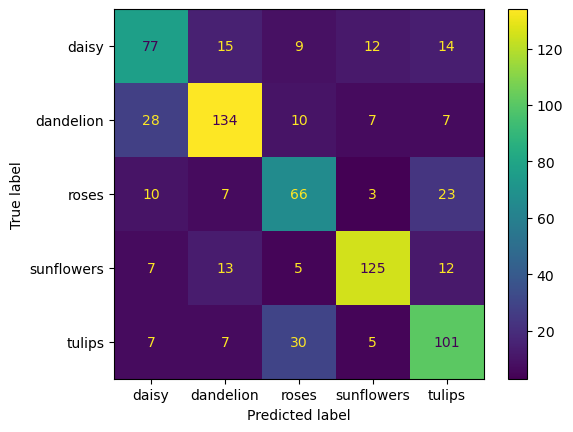

In [53]:
cm = metrics.confusion_matrix(predictions, true_categories)
metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=class_names).plot()

In [54]:
print(metrics.classification_report(predictions, true_categories))

              precision    recall  f1-score   support

       daisy       0.60      0.61      0.60       127
   dandelion       0.76      0.72      0.74       186
       roses       0.55      0.61      0.58       109
  sunflowers       0.82      0.77      0.80       162
      tulips       0.64      0.67      0.66       150

    accuracy                           0.69       734
   macro avg       0.67      0.68      0.67       734
weighted avg       0.69      0.69      0.69       734



## Adding in DropOut Layers

In [ ]:
num_classes = 5

# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Rescaling(1./255))
# model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D())
# model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D())
# model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D())
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(128, activation='relu'))
# model.add(tf.keras.layers.Dense(num_classes))

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [ ]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=600, 
    use_multiprocessing = True,
    callbacks=[early_stop, board]
)

## Evaluation

In [26]:
model.history.history

{'loss': [1.362580418586731,
  1.0670138597488403,
  0.9090647101402283,
  0.7754825353622437,
  0.6496963500976562,
  0.48969462513923645,
  0.36664658784866333,
  0.30166199803352356,
  0.29747968912124634,
  0.23890753090381622,
  0.18871569633483887,
  0.14475685358047485,
  0.08156599849462509,
  0.027041584253311157,
  0.015156394802033901,
  0.006603826303035021,
  0.004758007358759642,
  0.003101825714111328,
  0.0017882022075355053,
  0.0007307655178010464,
  0.0004907263210043311,
  0.00039016493246890604,
  0.00032057470525614917,
  0.00026879366487264633,
  0.000229387849685736,
  0.00019834088743664324,
  0.00017411189037375152,
  0.00015396546223200858,
  0.00013639283133670688,
  0.0001221163256559521,
  0.00010900165216298774,
  9.79937904048711e-05,
  8.902883564587682e-05,
  8.09649791335687e-05,
  7.335332338698208e-05,
  6.771073094569147e-05,
  6.14765813224949e-05,
  5.6619195675011724e-05,
  5.209132359595969e-05,
  4.795123459189199e-05,
  4.451896529644728e-05,

<Axes: >

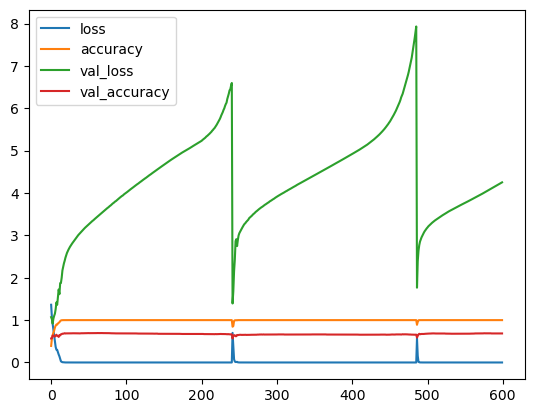

In [27]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [28]:
model.metrics_names

['loss', 'accuracy']

In [37]:
training_score = model.evaluate(train_ds,verbose=1)
test_score = model.evaluate(val_ds,verbose=1)

23/23 [==============================] - 1s 59ms/step - loss: 4.2521 - accuracy: 0.6853


In [38]:
print(training_score)
print(test_score)

[1.5749742487969343e-07, 1.0]
[4.252054214477539, 0.6852861046791077]


In [39]:
predictions = model.predict(val_ds)

23/23 [==============================] - 1s 59ms/step


In [40]:
predictions

array([[-8.0134420e+00,  1.1754016e+01, -2.6450163e+01, -4.2897366e+01,
        -1.5306821e+01],
       [ 9.6027384e+00, -1.2457906e+01, -2.0279449e+01, -7.2913394e+00,
        -4.6360135e+00],
       [ 3.7237201e+00, -1.0553655e+01, -2.3578381e+01,  5.3551259e+00,
        -6.5488000e+00],
       ...,
       [-6.5648189e+00, -4.4851546e+00, -1.1245485e+01, -1.6397329e+01,
        -1.3239042e+01],
       [ 1.1459247e+01,  1.2419254e-02, -3.2237415e+01, -3.5057388e+01,
        -2.1012194e+01],
       [-1.4171854e+01, -1.6599941e+00, -1.8085115e+01, -3.8836704e+01,
        -2.5030565e+01]], dtype=float32)

In [41]:
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [42]:
predictions = pd.Series(np.argmax(predictions,axis=1))

In [43]:
predictions

0      1
1      0
2      3
3      0
4      3
      ..
729    4
730    4
731    1
732    0
733    1
Length: 734, dtype: int64

In [44]:
predictions = pd.Series(predictions).replace(np.linspace(0,len(class_names)-1, len(class_names)), class_names)

In [45]:
predictions

0       dandelion
1           daisy
2      sunflowers
3           daisy
4      sunflowers
          ...    
729        tulips
730        tulips
731     dandelion
732         daisy
733     dandelion
Length: 734, dtype: object

In [46]:
true_categories = tf.concat([y for x, y in val_ds], axis=0).numpy()

In [47]:
true_categories

array([0, 4, 3, 0, 3, 4, 1, 2, 4, 0, 0, 0, 4, 4, 4, 3, 3, 0, 0, 3, 1, 4,
       4, 2, 3, 3, 1, 2, 1, 2, 4, 1, 1, 0, 2, 2, 3, 1, 3, 4, 2, 3, 4, 4,
       3, 4, 4, 3, 4, 1, 4, 1, 4, 1, 1, 1, 1, 2, 0, 2, 2, 1, 1, 1, 3, 1,
       0, 3, 4, 1, 0, 2, 3, 0, 3, 1, 0, 0, 3, 0, 4, 2, 3, 1, 4, 3, 1, 4,
       2, 1, 1, 0, 1, 2, 4, 2, 0, 2, 4, 3, 2, 1, 1, 2, 0, 0, 1, 4, 3, 0,
       4, 2, 0, 0, 0, 1, 0, 4, 4, 4, 0, 4, 4, 3, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 3, 0, 3, 4, 2, 3, 0, 3, 2, 2, 3, 2, 4, 3, 4, 0, 4, 2, 2, 0,
       2, 1, 0, 3, 2, 3, 0, 2, 4, 3, 0, 2, 3, 3, 4, 0, 1, 2, 3, 0, 4, 3,
       3, 1, 3, 2, 3, 1, 1, 2, 1, 4, 0, 1, 3, 3, 2, 2, 4, 1, 3, 1, 4, 1,
       1, 0, 1, 4, 3, 1, 1, 3, 3, 4, 1, 1, 0, 4, 1, 1, 1, 1, 3, 4, 3, 0,
       2, 2, 1, 4, 1, 1, 3, 1, 0, 0, 4, 4, 0, 1, 4, 3, 4, 4, 0, 2, 3, 3,
       3, 4, 0, 2, 4, 1, 1, 0, 1, 0, 3, 3, 4, 2, 0, 3, 4, 4, 1, 0, 2, 4,
       0, 2, 4, 4, 3, 1, 4, 2, 3, 3, 3, 3, 3, 1, 4, 4, 3, 2, 2, 3, 3, 0,
       3, 1, 1, 4, 4, 1, 4, 4, 3, 4, 0, 1, 1, 2, 0,

In [48]:
true_categories = pd.Series(true_categories).replace(np.linspace(0,len(class_names)-1, len(class_names)), class_names)

In [49]:
true_categories

0           daisy
1          tulips
2      sunflowers
3           daisy
4      sunflowers
          ...    
729        tulips
730        tulips
731        tulips
732         daisy
733     dandelion
Length: 734, dtype: object

In [50]:
metrics.accuracy_score(predictions, true_categories)

0.6852861035422343

In [51]:
metrics.confusion_matrix(predictions, true_categories)

array([[ 77,  15,   9,  12,  14],
       [ 28, 134,  10,   7,   7],
       [ 10,   7,  66,   3,  23],
       [  7,  13,   5, 125,  12],
       [  7,   7,  30,   5, 101]], dtype=int64)

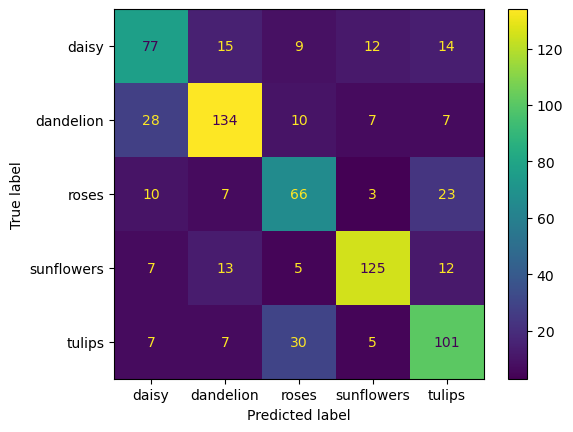

In [53]:
cm = metrics.confusion_matrix(predictions, true_categories)
metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=class_names).plot()

In [54]:
print(metrics.classification_report(predictions, true_categories))

              precision    recall  f1-score   support

       daisy       0.60      0.61      0.60       127
   dandelion       0.76      0.72      0.74       186
       roses       0.55      0.61      0.58       109
  sunflowers       0.82      0.77      0.80       162
      tulips       0.64      0.67      0.66       150

    accuracy                           0.69       734
   macro avg       0.67      0.68      0.67       734
weighted avg       0.69      0.69      0.69       734



# Despliegue

In [66]:
sunflowers = os.listdir(data_dir+'/sunflowers')
sunflowers = [data_dir + '/sunflowers/' + flower for flower in sunflowers] 

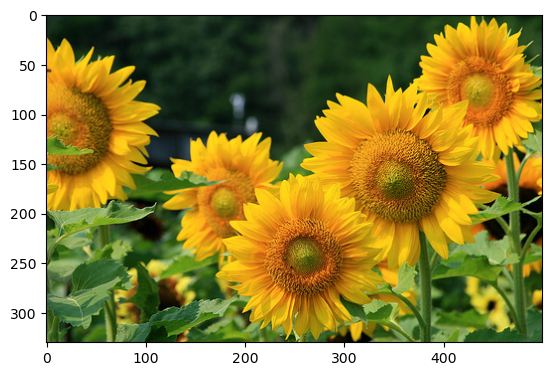

In [67]:
plt.imshow(imread(sunflowers[0]))

In [82]:
experimento = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=1)

Found 3670 files belonging to 5 classes.


In [83]:
experimento

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>